# Madness of March
## Jim Haines & Josh McCoy
### [Project Website](https://joshmccoy2.github.io/NCAA_March_Madness/)

## Current Datasets
[Kaggle datasets](https://www.kaggle.com/competitions/mens-march-mania-2022/data)

# ETL & EDA

In [2]:
# Import necessary libraries
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import xgboost as xgb
import requests
import numpy as np
import csv
import re
import time
import Levenshtein 
from io import StringIO
from io import StringIO
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import brier_score_loss, accuracy_score, confusion_matrix, classification_report, mean_absolute_error, mean_squared_error, r2_score, roc_curve, auc, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.feature_selection import SelectKBest, f_classif, f_regression
from scipy.special import expit 
from scipy.special import expit  
from xgboost import XGBClassifier
from bs4 import BeautifulSoup

We can first look at how some basic factors affect the amount the winning team wins by. We want to look at the difference in score to see how dominant a team is against a competitor. A team who wins by a lot is typically a sign that this team is significantly better than its oponent.

In [3]:
# To do this we can look at regular season game stats
detailed_results_data = 'MRegularSeasonDetailedResults.csv'
detailed_results = pd.read_csv(detailed_results_data)
detailed_results

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,...,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,...,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,...,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,...,16,17,27,21,15,12,10,7,1,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100418,2022,98,1400,79,1242,76,H,0,28,67,...,13,15,23,5,24,10,15,3,5,21
100419,2022,98,1411,66,1126,63,A,0,24,59,...,21,15,24,5,23,10,19,13,2,23
100420,2022,98,1422,68,1441,49,A,0,23,56,...,24,8,11,10,18,5,16,8,2,12
100421,2022,98,1438,69,1181,68,A,0,31,65,...,17,18,22,11,25,14,14,3,9,11



Let's check the datatypes

In [4]:
detailed_results.dtypes

Season      int64
DayNum      int64
WTeamID     int64
WScore      int64
LTeamID     int64
LScore      int64
WLoc       object
NumOT       int64
WFGM        int64
WFGA        int64
WFGM3       int64
WFGA3       int64
WFTM        int64
WFTA        int64
WOR         int64
WDR         int64
WAst        int64
WTO         int64
WStl        int64
WBlk        int64
WPF         int64
LFGM        int64
LFGA        int64
LFGM3       int64
LFGA3       int64
LFTM        int64
LFTA        int64
LOR         int64
LDR         int64
LAst        int64
LTO         int64
LStl        int64
LBlk        int64
LPF         int64
dtype: object

All the dtypes look correct, so lets move on to our analysis

In [5]:
# Create variable for amount by which winning team wins
detailed_results['SCOREDIFF'] = detailed_results['WScore'] - detailed_results['LScore']

When you see W or L this stands for Winning or Losing team.

In [6]:
# Winner stats
detailed_results.dtypes
detailed_results['WFGPCT'] = detailed_results['WFGM']/detailed_results['WFGA']       # field goal pt completion %
detailed_results['W3PCT'] = detailed_results['WFGM3']/detailed_results['WFGA3']      # 3 pt completion %
detailed_results['WFTPCT'] = detailed_results['WFTM']/detailed_results['WFTA']       # free throw completion %
detailed_results['WORBCHANCE'] =  detailed_results['WOR'] + detailed_results['LDR']  # total potential rebounds
detailed_results['WORPCT'] = detailed_results['WOR']/detailed_results['WORBCHANCE']  # rebound completion %

In [7]:
# Losing stats
detailed_results['LFGPCT'] = detailed_results['LFGM']/detailed_results['LFGA']       
detailed_results['L3PCT'] = detailed_results['LFGM3']/detailed_results['LFGA3']
detailed_results['LFTPCT'] = detailed_results['LFTM']/detailed_results['LFTA']
detailed_results['LORBCHANCE'] =  detailed_results['LOR'] + detailed_results['WDR']
detailed_results['LORPCT'] = detailed_results['LOR']/detailed_results['LORBCHANCE']

We can now take a more detailed look at the correlation between winner field goal % and score difference.

We can look at other factors as well:

Despite the common phrase "board man gets paid", we can see that there is a less strong correlation between rebound % and score difference. Perhaps this saying holds more true a higher level of play.

We can also take a look at detailed results from the actual tournament to see if there are any obvious differences from the regular season data. To do this we can replicate the above regular season analysis.

In [8]:
detailed_tourney_data = 'MNCAATourneyDetailedResults.csv'
detailed_tourney_results = pd.read_csv(detailed_tourney_data)
detailed_tourney_results

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,134,1421,92,1411,84,N,1,32,69,...,31,14,31,17,28,16,15,5,0,22
1,2003,136,1112,80,1436,51,N,0,31,66,...,16,7,7,8,26,12,17,10,3,15
2,2003,136,1113,84,1272,71,N,0,31,59,...,28,14,21,20,22,11,12,2,5,18
3,2003,136,1141,79,1166,73,N,0,29,53,...,17,12,17,14,17,20,21,6,6,21
4,2003,136,1143,76,1301,74,N,1,27,64,...,21,15,20,10,26,16,14,5,8,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1176,2021,148,1211,85,1425,66,N,0,33,66,...,15,14,19,7,20,9,9,7,0,13
1177,2021,148,1417,51,1276,49,N,0,21,54,...,11,6,11,8,24,12,14,5,3,11
1178,2021,152,1124,78,1222,59,N,0,29,55,...,19,11,16,13,12,10,10,4,5,10
1179,2021,152,1211,93,1417,90,N,1,37,63,...,17,14,21,7,24,21,9,4,1,16


In [9]:
detailed_tourney_results.dtypes

Season      int64
DayNum      int64
WTeamID     int64
WScore      int64
LTeamID     int64
LScore      int64
WLoc       object
NumOT       int64
WFGM        int64
WFGA        int64
WFGM3       int64
WFGA3       int64
WFTM        int64
WFTA        int64
WOR         int64
WDR         int64
WAst        int64
WTO         int64
WStl        int64
WBlk        int64
WPF         int64
LFGM        int64
LFGA        int64
LFGM3       int64
LFGA3       int64
LFTM        int64
LFTA        int64
LOR         int64
LDR         int64
LAst        int64
LTO         int64
LStl        int64
LBlk        int64
LPF         int64
dtype: object

In [10]:
#Create variable for amount by which winning team wins
detailed_tourney_results['SCOREDIFF'] = detailed_tourney_results['WScore'] - detailed_tourney_results['LScore']

In [11]:
# Winner stats
detailed_tourney_results.dtypes
detailed_tourney_results['WFGPCT'] = detailed_tourney_results['WFGM']/detailed_tourney_results['WFGA']       # field goal pt completion %
detailed_tourney_results['W3PCT'] = detailed_tourney_results['WFGM3']/detailed_tourney_results['WFGA3']      # 3 pt completion %
detailed_tourney_results['WFTPCT'] = detailed_tourney_results['WFTM']/detailed_tourney_results['WFTA']       # free throw completion %
detailed_tourney_results['WORBCHANCE'] =  detailed_tourney_results['WOR'] + detailed_tourney_results['LDR']  # total potential rebounds
detailed_tourney_results['WORPCT'] = detailed_tourney_results['WOR']/detailed_tourney_results['WORBCHANCE']  # rebound completion %

In [12]:
# Losing stats
detailed_tourney_results['LFGPCT'] = detailed_tourney_results['LFGM']/detailed_tourney_results['LFGA']       
detailed_tourney_results['L3PCT'] = detailed_tourney_results['LFGM3']/detailed_tourney_results['LFGA3']
detailed_tourney_results['LFTPCT'] = detailed_tourney_results['LFTM']/detailed_tourney_results['LFTA']
detailed_tourney_results['LORBCHANCE'] =  detailed_tourney_results['LOR'] + detailed_tourney_results['WDR']
detailed_tourney_results['LORPCT'] = detailed_tourney_results['LOR']/detailed_tourney_results['LORBCHANCE']

In [13]:
detailed_tourney_results.dtypes

Season          int64
DayNum          int64
WTeamID         int64
WScore          int64
LTeamID         int64
LScore          int64
WLoc           object
NumOT           int64
WFGM            int64
WFGA            int64
WFGM3           int64
WFGA3           int64
WFTM            int64
WFTA            int64
WOR             int64
WDR             int64
WAst            int64
WTO             int64
WStl            int64
WBlk            int64
WPF             int64
LFGM            int64
LFGA            int64
LFGM3           int64
LFGA3           int64
LFTM            int64
LFTA            int64
LOR             int64
LDR             int64
LAst            int64
LTO             int64
LStl            int64
LBlk            int64
LPF             int64
SCOREDIFF       int64
WFGPCT        float64
W3PCT         float64
WFTPCT        float64
WORBCHANCE      int64
WORPCT        float64
LFGPCT        float64
L3PCT         float64
LFTPCT        float64
LORBCHANCE      int64
LORPCT        float64
dtype: obj

In [14]:
detailed_tourney_results.head(1)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,WFGPCT,W3PCT,WFTPCT,WORBCHANCE,WORPCT,LFGPCT,L3PCT,LFTPCT,LORBCHANCE,LORPCT
0,2003,134,1421,92,1411,84,N,1,32,69,...,0.463768,0.37931,0.653846,42,0.333333,0.432836,0.387097,0.451613,47,0.361702


In [15]:
def prepare_data(df_data):
    df = df_data.copy()
    df.rename(columns = {'WLoc':'location'}, inplace = True )
    
    dfswap = df[['Season', 'DayNum', 'LTeamID', 'LScore', 'WTeamID', 'WScore', 'location', 'NumOT', 
    'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 
    'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF']]
    
    df.columns = df.columns.str.replace('W','T1_')
    df.columns = df.columns.str.replace('L','T2_')
    dfswap.columns = dfswap.columns.str.replace('L','T1_')
    dfswap.columns = dfswap.columns.str.replace('W','T2_')


    output = pd.concat([df, dfswap]).reset_index(drop=True)
    output.loc[output.location=='N','location'] = '0'
    output.loc[output.location=='H','location'] = '1'
    output.loc[output.location=='A','location'] = '-1'
    output.location = output.location.astype(int)
    output['PointDiff'] = output['T1_Score'] - output['T2_Score']
    output['Outcome'] = ((output['PointDiff'] > 0).astype(int))

    return output

In [16]:
tournament_data = prepare_data(detailed_tourney_results)

In [17]:
tournament_data

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,location,NumOT,T1_FGM,T1_FGA,...,T1_FTPCT,T1_ORBCHANCE,T1_ORPCT,T2_FGPCT,T2_3PCT,T2_FTPCT,T2_ORBCHANCE,T2_ORPCT,PointDiff,Outcome
0,2003,134,1421,92,1411,84,0,1,32,69,...,0.653846,42.0,0.333333,0.432836,0.387097,0.451613,47.0,0.361702,8,1
1,2003,136,1112,80,1436,51,0,0,31,66,...,0.785714,37.0,0.297297,0.312500,0.250000,1.000000,44.0,0.181818,29,1
2,2003,136,1113,84,1272,71,0,0,31,59,...,0.727273,32.0,0.312500,0.362319,0.250000,0.666667,47.0,0.425532,13,1
3,2003,136,1141,79,1166,73,0,0,29,53,...,0.720000,28.0,0.392857,0.450000,0.411765,0.705882,34.0,0.411765,6,1
4,2003,136,1143,76,1301,74,0,1,27,64,...,0.652174,44.0,0.409091,0.446429,0.428571,0.750000,30.0,0.333333,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2357,2021,148,1425,66,1211,85,0,0,24,62,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-19,0
2358,2021,148,1276,49,1417,51,0,0,20,51,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2,0
2359,2021,152,1222,59,1124,78,0,0,21,55,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-19,0
2360,2021,152,1417,90,1211,93,0,1,34,59,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3,0


In [18]:
detailed_tourney_results.columns

Index(['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc',
       'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF',
       'SCOREDIFF', 'WFGPCT', 'W3PCT', 'WFTPCT', 'WORBCHANCE', 'WORPCT',
       'LFGPCT', 'L3PCT', 'LFTPCT', 'LORBCHANCE', 'LORPCT'],
      dtype='object')

In [19]:
# Choose the features that you want
boxscore_cols = ['T1_Score', 'T2_Score',
        'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_OR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_PF', 
        'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_OR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk',  
        'PointDiff']

In [20]:
# Get season averages by team and yearb
funcs = [np.mean]
season_statistics = tournament_data.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg(funcs).reset_index()
season_statistics.columns = [''.join(col).strip() for col in season_statistics.columns.values]
season_statistics

,Season,T1_TeamID,T1_Scoremean,T2_Scoremean,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,...,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_Blkmean,PointDiffmean
0,2003,1104,62.000000,67.00,22.000000,52.000000,5.00,12.000000,9.000000,13.000000,...,19.0,49.00,7.000000,18.000000,13.0,15.00,8.000000,1.0,2.00,-5.000000
1,2003,1112,84.750000,73.75,31.000000,67.750000,7.75,20.750000,13.500000,18.750000,...,27.0,66.75,8.250000,23.750000,12.0,15.75,15.500000,8.5,4.25,11.000000
2,2003,1113,80.000000,89.50,29.500000,64.000000,5.00,14.500000,13.500000,14.500000,...,32.5,64.00,6.000000,18.500000,16.0,16.00,12.500000,4.0,5.50,-9.500000
3,2003,1120,70.333333,68.00,25.333333,58.666667,7.00,19.666667,13.333333,12.333333,...,23.0,58.00,6.333333,20.333333,14.0,10.00,13.333333,8.0,6.00,2.333333
4,2003,1122,64.000000,86.00,24.000000,54.000000,2.00,21.000000,8.000000,11.000000,...,35.0,70.00,8.000000,24.000000,15.0,18.00,12.000000,12.0,4.00,-22.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1194,2021,1439,70.000000,75.00,24.000000,57.000000,7.00,23.000000,6.000000,11.000000,...,26.0,46.00,5.000000,13.000000,5.0,9.00,15.000000,5.0,3.00,-5.000000
1195,2021,1452,78.000000,71.00,29.000000,66.500000,10.00,22.000000,13.000000,17.000000,...,26.5,51.00,12.000000,25.000000,5.5,16.50,16.500000,5.0,5.50,7.000000
1196,2021,1455,52.000000,53.00,19.000000,56.000000,3.00,18.000000,10.000000,7.000000,...,20.0,53.00,7.000000,19.000000,5.0,13.00,11.000000,4.0,5.00,-1.000000
1197,2021,1457,63.000000,73.00,21.000000,58.000000,7.00,22.000000,9.000000,13.000000,...,23.0,52.00,8.000000,25.000000,6.0,11.00,6.000000,3.0,8.00,-10.000000


In [21]:
tournament_data = pd.merge(tournament_data, season_statistics, on = ['Season', 'T1_TeamID'], how = 'left')

In [22]:
tournament_data.columns

Index(['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID', 'T2_Score',
       'location', 'NumOT', 'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_FTM',
       'T1_FTA', 'T1_OR', 'T1_DR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_Blk',
       'T1_PF', 'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_FTM', 'T2_FTA',
       'T2_OR', 'T2_DR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk', 'T2_PF',
       'SCOREDIFF', 'T1_FGPCT', 'T1_3PCT', 'T1_FTPCT', 'T1_ORBCHANCE',
       'T1_ORPCT', 'T2_FGPCT', 'T2_3PCT', 'T2_FTPCT', 'T2_ORBCHANCE',
       'T2_ORPCT', 'PointDiff', 'Outcome', 'T1_Scoremean', 'T2_Scoremean',
       'T1_FGMmean', 'T1_FGAmean', 'T1_FGM3mean', 'T1_FGA3mean', 'T1_ORmean',
       'T1_Astmean', 'T1_TOmean', 'T1_Stlmean', 'T1_PFmean', 'T2_FGMmean',
       'T2_FGAmean', 'T2_FGM3mean', 'T2_FGA3mean', 'T2_ORmean', 'T2_Astmean',
       'T2_TOmean', 'T2_Stlmean', 'T2_Blkmean', 'PointDiffmean'],
      dtype='object')

# Pipeline


This pipeline automates the evaluation of machine learning models on basketball game data across various seasons. 

Key features include:
- Season-wise Data Processing: Analyzes data for each season separately, catering to year-specific trends.
- Flexible Feature Selection: Allows easy customization of input features for analysis.
- Multiple Model Evaluation: Tests different models (like Logistic Regression, XGBoost, and Linear Regression) and compares their performances.
- Data Standardization: Scales features to ensure fair model comparison.
- Robustness Checks: Identifies and handles missing data for each season.
- Performance Metrics: Calculates key metrics to assess each model's accuracy and effectiveness.
- Result Visualization: Provides graphical representations for easier interpretation of model performances.

  
This pipeline is designed for efficiently processing new data and quickly assessing the impact of different features on model predictions.

In [31]:
import xgboost as xgb
from sklearn.model_selection import KFold
import numpy as np
from sklearn import preprocessing


# Assuming you have defined your features and target variable
features = ['Season', 'DayNum', 'T1_TeamID', 'T2_TeamID', 'T1_Score', 'T2_Score', 'NumOT', 'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_FTM', 'T1_FTA', 'T1_OR', 'T1_DR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_Blk', 'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_FTM', 'T2_FTA', 'T2_OR', 'T2_DR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk', 'T1_FGPCT', 'T1_3PCT', 'T1_FTPCT', 'T1_ORBCHANCE', 'T1_ORPCT', 'T2_FGPCT', 'T2_3PCT', 'T2_FTPCT', 'T2_ORBCHANCE', 'T2_ORPCT', 'PointDiff', 'T1_Scoremean', 'T2_Scoremean', 'T1_FGMmean', 'T1_FGAmean', 'T1_FGM3mean', 'T1_FGA3mean', 'T1_ORmean', 'T1_Astmean', 'T1_TOmean', 'T1_Stlmean', 'T1_PFmean', 'T2_FGMmean', 'T2_FGAmean', 'T2_FGM3mean', 'T2_FGA3mean', 'T2_ORmean', 'T2_Astmean', 'T2_TOmean', 'T2_Stlmean', 'T2_Blkmean', 'PointDiffmean']
target = 'Outcome'  # Assuming 'Outcome' is your target variable

# Assuming you have your dataset stored in tournament_data
df = tournament_data.copy()

# Preparing ID column
df.insert(0, "ID", "")
df.ID = [str(row.Season) + "_" + str(row.T1_TeamID) + "_" + str(row.T2_TeamID) for _, row in df.iterrows()]
df = df.fillna(0)

normalize = "MinMaxScaler"

# Assuming you have defined your normalization technique in 'normalize' variable
if normalize == "MinMaxScaler":
    min_max_scaler = preprocessing.MinMaxScaler()
    df[features] = min_max_scaler.fit_transform(df[features])
elif normalize == "StandardScaler":
    standard_scaler = preprocessing.StandardScaler()
    df[features] = standard_scaler.fit_transform(df[features])
elif normalize == "Normalizer":
    normalizer = preprocessing.Normalizer(norm='max')
    df[features] = normalizer.fit_transform(df[features])

# Defining parameters for XGBoost
param = {
    'objective': 'binary:logistic',  # Assuming it's a binary classification problem
    'eval_metric': 'logloss',  # You can change the evaluation metric as per your requirement
    'eta': 0.1,
    'max_depth': 6,
    'min_child_weight': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 0,
    'seed': 42  # You can change the seed value as per your requirement
}

# Defining custom objective function (cauchyobj)
def cauchyobj(preds, dtrain):
    labels = dtrain.get_label()
    c = 5000
    x = preds - labels
    grad = x / (x ** 2 / c ** 2 + 1)
    hess = -(c ** 2) * (x ** 2 - c ** 2) / (x ** 2 + c ** 2) ** 2
    return grad, hess

# Defining seasons and other variables
season = 2021
repeat_cv = 4
seasons = df['Season'].unique().tolist()
print("Seasons:", seasons)
print(f'Validating on season: {season}')

# Splitting data into train and validation sets based on season
df_train = df[df['Season'] <= season].reset_index(drop=True).copy()
df_val = df[df['Season'] == season].reset_index(drop=True).copy()

# Defining X and y for training
y_train = df_train[target]
X_train = df_train[features].values

# Creating DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)

# Cross-validation using XGBoost
xgb_cv = []
for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    xgb_cv.append(
        xgb.cv(
            params=param,
            dtrain=dtrain,
            obj=cauchyobj,
            num_boost_round=3000,
            folds=KFold(n_splits=5, shuffle=True, random_state=i),
            early_stopping_rounds=25,
            verbose_eval=50
        )
    )

# Getting iteration counts and validation MAE
iteration_counts = [np.argmin(x['test-logloss-mean'].values) for x in xgb_cv]
val_logloss = [np.min(x['test-logloss-mean'].values) for x in xgb_cv]

print("Iteration Counts:", iteration_counts)
print("Validation Log Loss:", val_logloss)


Seasons: [0.0, 0.055555555555557135, 0.11111111111111427, 0.1666666666666714, 0.22222222222222854, 0.27777777777777146, 0.3333333333333286, 0.38888888888888573, 0.44444444444444287, 0.5, 0.5555555555555571, 0.6111111111111143, 0.6666666666666714, 0.7222222222222285, 0.7777777777777715, 0.8333333333333286, 0.8888888888888857, 1.0]
Validating on season: 2021
Fold repeater 0
[0]	train-logloss:0.66880+0.00023	test-logloss:0.66880+0.00091
[50]	train-logloss:0.50384+0.00178	test-logloss:0.50385+0.00711
[100]	train-logloss:0.50321+0.00178	test-logloss:0.50323+0.00713
[119]	train-logloss:0.50321+0.00178	test-logloss:0.50323+0.00713
Fold repeater 1
[0]	train-logloss:0.66880+0.00014	test-logloss:0.66880+0.00055
[50]	train-logloss:0.50384+0.00107	test-logloss:0.50387+0.00428
[100]	train-logloss:0.50321+0.00107	test-logloss:0.50325+0.00429
[118]	train-logloss:0.50321+0.00107	test-logloss:0.50325+0.00429
Fold repeater 2
[0]	train-logloss:0.66880+0.00017	test-logloss:0.66880+0.00069
[50]	train-loglo

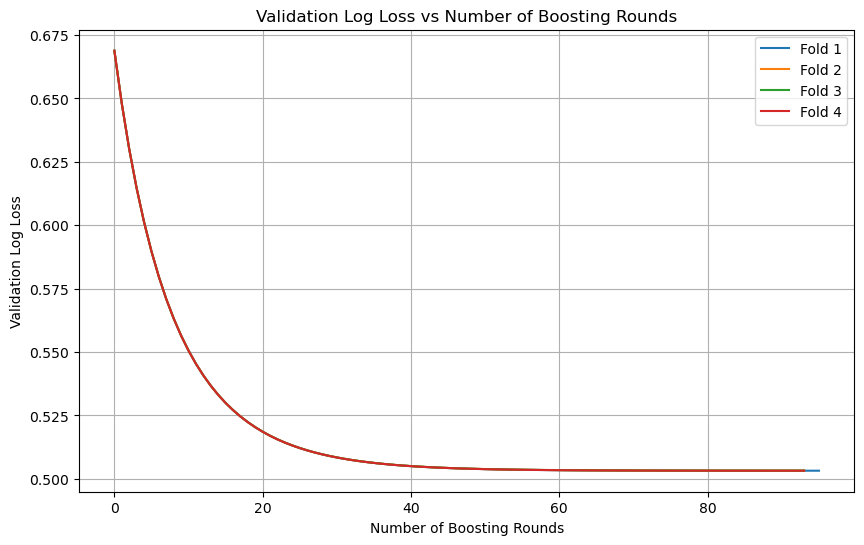

In [32]:
plt.figure(figsize=(10, 6))
for i in range(repeat_cv):
    plt.plot(xgb_cv[i]['test-logloss-mean'], label=f'Fold {i+1}')

plt.xlabel('Number of Boosting Rounds')
plt.ylabel('Validation Log Loss')
plt.title('Validation Log Loss vs Number of Boosting Rounds')
plt.legend()
plt.grid(True)
plt.show()

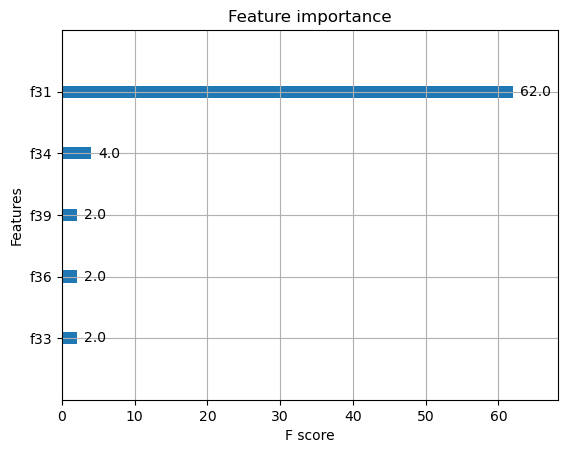

In [33]:
best_iteration = np.mean(iteration_counts)
final_model = xgb.train(
    params=param,
    dtrain=dtrain,
    num_boost_round=int(best_iteration)
)

# Plot feature importance
xgb.plot_importance(final_model)
plt.show()

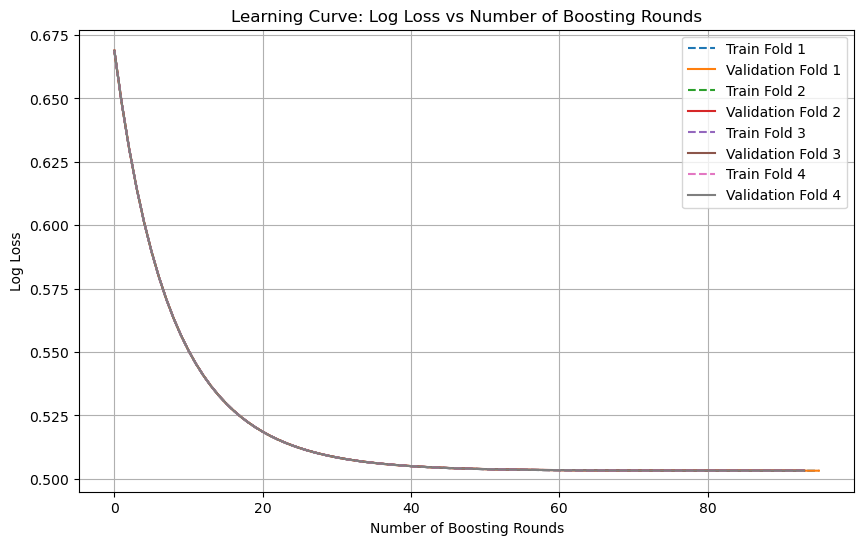

In [34]:
plt.figure(figsize=(10, 6))
for i in range(repeat_cv):
    plt.plot(xgb_cv[i]['train-logloss-mean'], label=f'Train Fold {i+1}', linestyle='--')
    plt.plot(xgb_cv[i]['test-logloss-mean'], label=f'Validation Fold {i+1}')

plt.xlabel('Number of Boosting Rounds')
plt.ylabel('Log Loss')
plt.title('Learning Curve: Log Loss vs Number of Boosting Rounds')
plt.legend()
plt.grid(True)
plt.show()

In [36]:
from sklearn.metrics import confusion_matrix

# Train XGBoost model with optimal number of boosting rounds
final_model = xgb.train(
    params=param,
    dtrain=dtrain,
    num_boost_round=int(best_iteration)
)

# Make predictions on validation data
y_pred = final_model.predict(xgb.DMatrix(df_val[features]))

# Convert predicted probabilities to binary predictions
y_pred_binary = np.where(y_pred > 0.5, 1, 0)

# Calculate confusion matrix
cm = confusion_matrix(df_val[target], y_pred_binary)

# Plot confusion matrix
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


[10:31:35] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:1517: Empty dataset at worker: 0


ValueError: Classification metrics can't handle a mix of binary and unknown targets

# All Models Analysis 

In [ ]:
# Compare Brier Score across 3 models
brier_score_column_name = 'Brier Score'  

# Melt the dataframes
log_reg_melted = logistic_df.melt(id_vars=['Season'], value_vars=[brier_score_column_name], 
                                       var_name='Metric', value_name='Score')

log_reg_melted['Model'] = 'Logistic Regression'

xgb_melted = xgBoost_df.melt(id_vars=['Season'], value_vars=[brier_score_column_name], 
                               var_name='Metric', value_name='Score')
xgb_melted['Model'] = 'XGBoost'

lin_reg_melted = linear_df.melt(id_vars=['Season'], value_vars=[brier_score_column_name], 
                                       var_name='Metric', value_name='Score')

lin_reg_melted['Model'] = 'Linear Regression'

# Combine all the melted dataframes
combined_melted = pd.concat([log_reg_melted, xgb_melted, lin_reg_melted])

# Create the box plots
plt.figure(figsize=(10, 6))
sns.boxplot(x='Metric', y='Score', hue='Model', data=combined_melted)
plt.title('Comparison of Brier Scores Among Logistic Regression, XGBoost, and Linear Regression Models')
plt.show()

In [ ]:
# Plotting Brier Score for all models
plt.figure(figsize=(12, 6))
sns.lineplot(data=results_df, x='Season', y='Brier Score', hue='Model', marker='o')
plt.title('Brier Score Comparison Over Seasons')
plt.ylabel('Brier Score')
plt.show()

In [ ]:
# Plotting MAE and MSE for Linear Regression
sns.lineplot(data=linear_df, x='Season', y='MAE', marker='o', label='MAE')
sns.lineplot(data=linear_df, x='Season', y='MSE', marker='o', label='MSE')
plt.title('Linear Regression: MAE and MSE Over Seasons')
plt.ylabel('Error')
plt.legend()
plt.show()

# XG Boost Analysis 

In [ ]:
# Plot metrics accross seasons

# Formatting
sns.set(style="whitegrid")
fig, axes = plt.subplots(3, 2, figsize=(15, 10))
fig.suptitle('XGBoost Model Performance Over Seasons')

# Plot each metric
sns.lineplot(x='Season', y='Accuracy', data=xgBoost_df, ax=axes[0, 0])
sns.lineplot(x='Season', y='Precision', data=xgBoost_df, ax=axes[0, 1])
sns.lineplot(x='Season', y='Recall', data=xgBoost_df, ax=axes[1, 0])
sns.lineplot(x='Season', y='F1 Score', data=xgBoost_df, ax=axes[1, 1])
sns.lineplot(x='Season', y='ROC AUC', data=xgBoost_df, ax=axes[2, 0])
sns.lineplot(x='Season', y='Brier Score', data=xgBoost_df, ax=axes[2, 1])


plt.tight_layout()
plt.show()